# Notebook 1 

## Here, we perform:
    1. Unbinding trajectory loading, alignment, variable selection
    2. PCA projection
    3. Unbinding path construction
    4. Milestone (disk) construction & optimization
    5. Frame sorting if necessary

## Import required libraries

In [1]:
# required side libs
import pytraj as pt
from sklearn.decomposition import PCA
import numpy as np
import scipy
import warnings
warnings.filterwarnings("ignore")
#from scipy import spatial

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d

# BKiT
from BKit.SmoothPath import BuildSmoothMeanPath
from BKit.Utils import LoadTrajs, SplitEvenOdd, PlotSelected, pathpatch_2d_to_3d
from BKit.InterpolateCurve import InterpolatePath
from BKit.ConstructMilestones3D import ConstructMilestones3D
from BKit.ConstructMilestones3D import SortFrames, rotation_matrix

## Set model parameters

In [2]:
# parameters
dim = 3            # pc dimention    
w_size = 50        # rolling ave window size, which is used as reference path
stride = w_size//5 # rolling ave stride, num of frames to skip between windows 
ml_length = .80    # distance between milestones
n_iter = 8000      # number of iterations for ML disk normal optimization
thresh = -0.27     # threshold to remove points (thresh = cos(alpha), thresh=0.0 means angle is 90) 
dr = 2.            # disk radius (milestone size)  

dz = ml_length/8   # distance from disk to select points (only used to select frames for later processing) 
yz_pad = 8         # yz pad length to avoid disk distortion upon visualization 



## Set  path to all input files & load trajectories

* Align all frames using 7 O1 atoms that makes a circle in bCD
* Select O1, C1, C2 atoms from bCD, and all heavy atoms of aspiring as variables for PCA

In [3]:
DIR_SAVE = '../output/'
complex_name = 'bCD-asp'

path = '/data4/talant/Cyclodex/data/'
TOP = path + 'cd_asp_protein.prmtop'

TRAJ = path + 'Representative/' + 'short_be16_pca.dcd'
pdb_path = path + 'cd_asp_reference.pdb'

mask_align = "(:1-7)&(@O1)" 
mask_selec = ['@O1,C1,C2,:8','!@H*']

new_frames, refframe, traj= LoadTrajs(traj_path = TRAJ,
                                    top_path = TOP,
                                    refPDB_path = pdb_path,
                                    mask_selec = mask_selec,
                                    mask_align = mask_align)

Total number of residues --  8
Total number of atoms --  168
Total number of frames --  430
Loading metadynamics trajectory by chunk... 


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 412.03it/s]

Total number of selected atoms --  34


## Perform PCA Projection

In [7]:
pca = PCA(n_components=dim)
PCs = pca.fit_transform(new_frames)
  
# obtain eigvals and eigvecs
eigvals = pca.explained_variance_ratio_
eigvecs = pca.components_.T
  
dat = np.concatenate((np.dot(new_frames, eigvecs[:,0]).reshape(len(new_frames),1),
                      np.dot(new_frames, eigvecs[:,1]).reshape(len(new_frames),1),
                      np.dot(new_frames, eigvecs[:,2]).reshape(len(new_frames),1)),
                      axis=1)
print('Coverage',round(sum(pca.explained_variance_ratio_)*100,1))

Coverage 83.8


## Visualize PCA Space

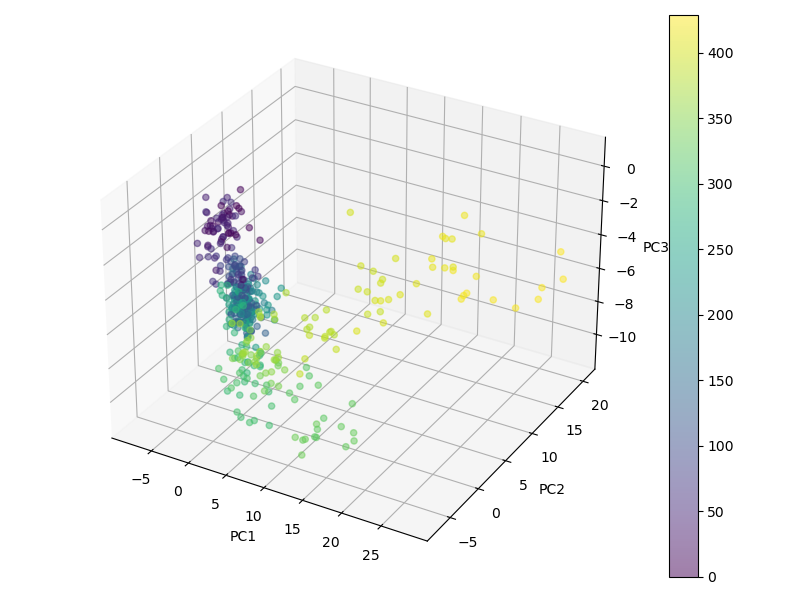

In [8]:
%matplotlib widget
fig = plt.figure(figsize = [8, 6])
ax = plt.axes(projection = '3d')
p = ax.scatter3D(dat[:,0], dat[:,1], dat[:,2], c = range(int(len(dat))), alpha=0.5)
fig.colorbar(p, ax = ax)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.tight_layout()
#plt.savefig(FIG_SAVE + complex_name + '3D_PCA.png', dpi=600)
plt.show()

Note!
* Every point represents conformation of the entire complex
* Coloring is applied using frame indecies assuming they represent continuous dissociation (transiton), but often not true.


## Construct 3D Path

In [15]:
# this constructs 3D path
SReactPath = BuildSmoothMeanPath(dat, w_size=w_size, thresh=thresh, stride=stride)    
meanP = SReactPath.GetPath()

# crude path to compare
CrudePath = SReactPath.roll_ave(w_size=w_size//2, stride=stride//2)

# kd-path re-evaluates mean path
kd_path = SReactPath.GetPathKD(rad=dr, w_size=w_size, stride=stride)

#interpolate paths  
InterPath = InterpolatePath(meanP, pair_dist = ml_length , dim=dim, kind='linear')
InterPathKD = InterpolatePath(kd_path, pair_dist = ml_length , dim=dim, kind='linear')

## Visualize crude path vs constructed smooth path

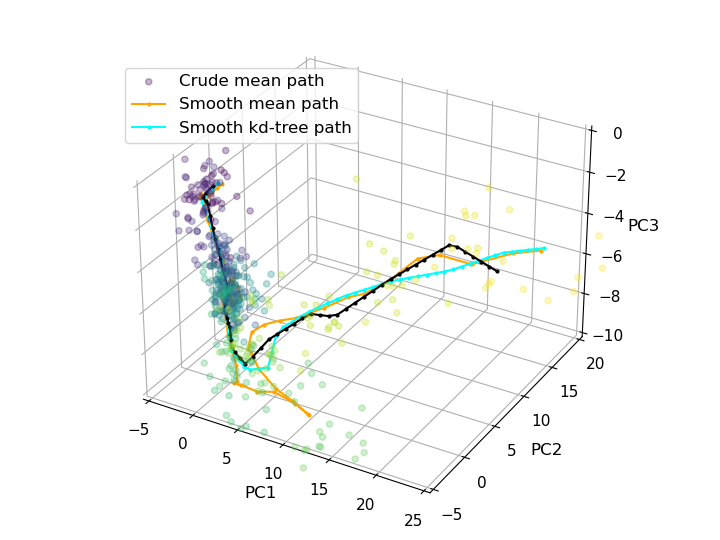

In [14]:
%matplotlib widget
plotOrig = True
fs = 12

fig = plt.figure(figsize = [7.2, 5.4])
ax = plt.axes(projection='3d')

if plotOrig:
    p = ax.scatter3D(dat[:,0], dat[:,1], dat[:,2], c=range(int(len(dat))), alpha=0.3)
    #fig.colorbar(p, ax=ax)

ax.plot3D(CrudePath[:,0], CrudePath[:,1], CrudePath[:,2], 'orange', marker='o', markersize=2)
ax.plot3D(InterPath[:,0], InterPath[:,1], InterPath[:,2], 'cyan', ls='-', marker='o', markersize=2)
ax.plot3D(InterPathKD[:,0], InterPathKD[:,1], InterPathKD[:,2], 'black', ls='-', marker='o', markersize=2)

ax.set_xlabel('PC1', fontsize=fs)
ax.set_ylabel('PC2',fontsize=fs)
ax.set_zlabel('PC3',fontsize=fs)
ax.set_xlim3d(-5,25); ax.set_ylim3d(-5,20); ax.set_zlim3d(-10,0)
plt.legend(["Crude mean path", "Smooth mean path", 'Smooth kd-tree path'],loc=[0.04,0.75], fontsize=fs)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.set_tick_params(labelsize=fs-1)
ax.yaxis.set_tick_params(labelsize=fs-1)
ax.zaxis.set_tick_params(labelsize=fs-1)
#ax.set_axis_off()

fig.tight_layout()
#plt.savefig(FIG_SAVE + complex_name + '3D_path.png', dpi=600)
plt.show()

## Milestone Construction

1. We use the half distance between the path points, then position pseudo disks at middle positions.
2. One can use `SplitEvenOdd` function to get either middle positions or actuall disk positions
3. Numerically unit vectors also can represent a plane. We use 3D unit vectors normal to the disk surface to represent a disk.


### Apply interpolation with equidistant partitioning of path using half half distance  between the path points


In [20]:
#pathAll = InterpolatePath(meanP, pair_dist=ml_length/2, dim=dim, kind='linear')
pathAll = InterpolatePath(kd_path, pair_dist=ml_length/2, dim=dim, kind='linear')

#split into barriers and states
diskID, midID = SplitEvenOdd(N=pathAll.shape[0])
pathMid = pathAll[midID]
pathP = pathAll[diskID]    

### Construct disks

In [21]:
# construct 3D milestones (disks)
ConsMile = ConstructMilestones3D(pathAll)
vecs = ConsMile.GetVectors()
normals = vecs[diskID] 

### Optimize via Mean Field Method

In [22]:
normalsAll = ConsMile.OptVectors(vecs, n_iter=n_iter, lr=0.01)
#split to state and barriers
normals = normalsAll[diskID]       # barrier disk vectors
normalsMid = normalsAll[midID]     # mid disk vectors

In [23]:
n_disks = normals.shape[0]        # also number of barriers
n_cells = normalsMid.shape[0]     # also number of states
print('Number of disks -- ', n_disks)
print('Number of cells -- ', n_cells)

Number of disks --  56
Number of cells --  55


### Plot Optimized Disks

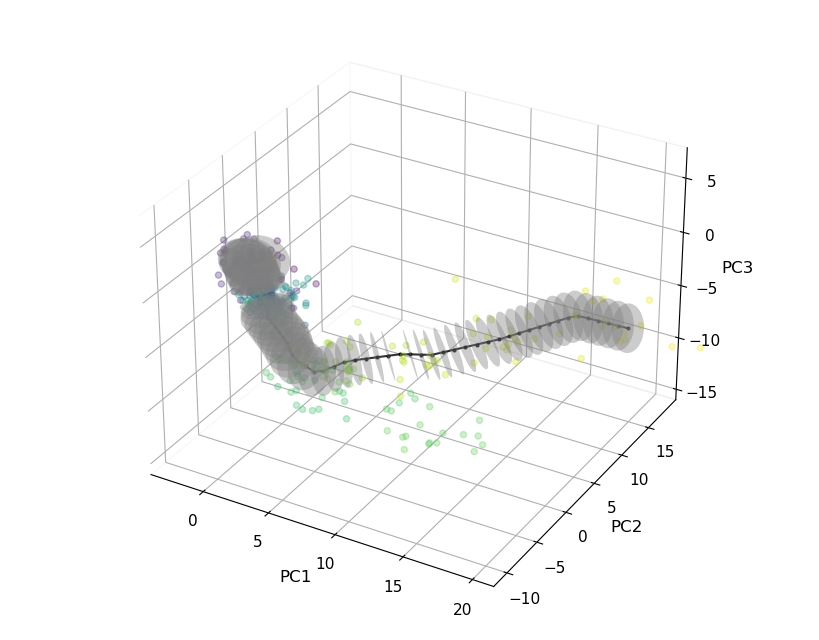

In [34]:
%matplotlib widget
plotOrig = True
fig = plt.figure(figsize = [8.2, 6.4])
ax = plt.axes(projection='3d')
fs = 12   

if plotOrig: #plot original points
    p = ax.scatter3D(dat[:,0], dat[:,1], dat[:,2], c=range(int(len(dat))), alpha=0.3)

#plot path
ax.plot3D(pathP[:,0], pathP[:,1], pathP[:,2], c='black', marker='o', markersize=2, alpha=0.8)

#plot disks
for i in range(n_disks):
    c = Circle((0,0), dr, facecolor='grey', alpha=0.4)
    ax.add_patch(c)
    pathpatch_2d_to_3d(c, pathP[i], normal = normals[i])
       
ax.set_xlabel('PC1', fontsize=fs)
ax.set_ylabel('PC2',fontsize=fs)
ax.set_zlabel('PC3',fontsize=fs)
x_min, y_min, z_min = pathP.min(axis=0) 
x_max, y_max, z_max = pathP.max(axis=0)
ax.set_xlim3d(x_min, x_max)
ax.set_ylim3d(y_min - yz_pad, y_max + yz_pad)
ax.set_zlim3d(z_min - yz_pad, z_max + yz_pad)
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
#ax.xaxis.pane.set_edgecolor('w'); ax.yaxis.pane.set_edgecolor('w'); ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.set_tick_params(labelsize=fs-1)
ax.yaxis.set_tick_params(labelsize=fs-1)
ax.zaxis.set_tick_params(labelsize=fs-1)
fig.tight_layout()
plt.show()    

## Sort points on disk surface or between disks 

In [35]:
SortF = SortFrames(dat,dr,dz)
datDS, _ = SortF.SortAllPoints(normals, normalsMid, pathP, pathMid, SortMethod='middle')

In [36]:
selected_frames = np.array(datDS[:,4], dtype=int)
datOut = dat[~selected_frames]

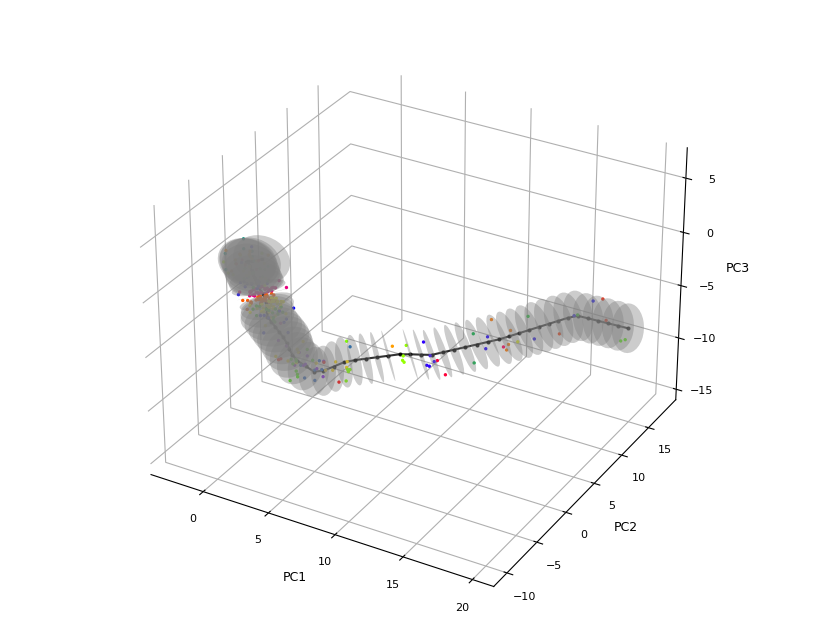

In [37]:
%matplotlib widget
plotOrig = True
dat_sel = datDS
fig = plt.figure(figsize = [8.2, 6.4])
ax = plt.axes(projection='3d')
fs=9   

#plot path poits
ax.plot3D(pathP[:,0], pathP[:,1], pathP[:,2], c='black', marker='o', markersize=2, alpha=0.8)
ax.set_xlabel('PC1', fontsize=fs)
ax.set_ylabel('PC2',fontsize=fs)
ax.set_zlabel('PC3',fontsize=fs)

#plotting disks
for i in range(n_disks):
    c = Circle((0,0), dr, facecolor='grey', alpha=0.4)
    ax.add_patch(c)
    pathpatch_2d_to_3d(c, pathP[i], normal = normals[i])

#plot selected points
p = ax.scatter3D(dat_sel[:,0], dat_sel[:,1], dat_sel[:,2], c = dat_sel[:,3],
                 alpha=1.0, s = 2., cmap = 'prism')
#p = ax.scatter3D(datOut[:,0], datOut[:,1], datOut[:,2], c = 'grey')
    
x_min, y_min, z_min = pathP.min(axis=0) 
x_max, y_max, z_max = pathP.max(axis=0)
ax.set_xlim3d(x_min, x_max)
ax.set_ylim3d(y_min - yz_pad, y_max + yz_pad)
ax.set_zlim3d(z_min - yz_pad, z_max + yz_pad)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.set_tick_params(labelsize=fs-1)
ax.yaxis.set_tick_params(labelsize=fs-1)
ax.zaxis.set_tick_params(labelsize=fs-1)
fig.tight_layout()
plt.show()    


- Save disk positions and unit vectore `MlPosNorms.npy` file
- Save eigen vectors of the PCA projection `EigVecs.npy` file
- Save reference frame as `.npy`


In [38]:
print("writing outputs to " + DIR_SAVE)
np.save(DIR_SAVE + '/MlPosNorms.npy', np.column_stack([pathAll, normalsAll]))
np.save(DIR_SAVE + '/EigVecs.npy', eigvecs)
np.save(DIR_SAVE + '/RefFrame.npy', refframe)

writing outputs to ../output/


## Select frames on disks and save as `.dcd` files associated with unbinding index. 

In [18]:
for i in range(n_disks):
    sel_frames = np.array(datDS[datDS[:,3]==i][:,4], dtype=int)
    if sel_frames.size != 0:
        pt.write_traj(DIR_SAVE + 'UnbindIndx' + str(i) + '.dcd',
                      traj[sel_frames],
                      overwrite=True)
    else:
        print('Empty Disk ID', i)

Empty Disk ID 17
Empty Disk ID 31
Empty Disk ID 32
Empty Disk ID 33
Empty Disk ID 38
Empty Disk ID 39
Empty Disk ID 45
Empty Disk ID 47
Empty Disk ID 49
Empty Disk ID 52
Empty Disk ID 57
Empty Disk ID 58
Empty Disk ID 59
Empty Disk ID 60
Empty Disk ID 61


# Done!